In [7]:
# Load Required Packages
import sklearn
import statistics
import scipy as sc
import numpy as np
import pandas as pd
import random
import cvxpy as cp
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
import time
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import mosek
import statsmodels.api as sm
import gc
import pickle
import seaborn as sns
from pmlb import fetch_data
from pmlb import classification_dataset_names, regression_dataset_names
from sklearn.feature_selection import  RFE

data_details = pd.read_csv('pmlb_meta.csv')

In [26]:
def plot_tradeoff_curve(test_acc,nonzero,color,label):
    results = pd.DataFrame()
    for i in range(0,len(test_acc)):
        results = results.append(pd.DataFrame(np.column_stack((test_acc[i],nonzero[i])),columns = ['test_acc','nonzero']))
    agg = results.groupby(['nonzero'], as_index=False).agg({'test_acc':['mean','std','count']})
    
    plt.scatter(agg['nonzero'],agg['test_acc']['mean'],color = color,label = label)
    plt.errorbar(agg['nonzero'],agg['test_acc']['mean'], agg['test_acc']['std'],color = color)
    plt.xlabel('Number of Nonzero Features')
    plt.ylabel('Test Error')
    plt.legend()
    
    
def converge_test(sequence, threshold,length):
    diff = np.diff(sequence)
    if len(diff) < (length+1):
        return False
    else:
        return ( max(np.abs(diff[-length:])) < threshold)
    
def build_trees_bag(arg):
    xTrain = arg[0]
    yTrain = arg[1]a
    xTest= arg[2]
    yTest= arg[3]
    max_depth= arg[4]
    problem_type = arg[5]
    loss_type = arg[6]
    lambd= arg[7]
    threshold= arg[8] 
    sketch = arg[9]
   
    train = xTrain
    train = train.reset_index().drop('index',axis = 1)
    train['yTrain'] = list(yTrain)
    features = xTrain.columns
    nfeatures = len(features)
    importance_key = pd.DataFrame(features,columns = ['Features'])
    tree_results = []
    i = 0
    depth = 1
    total_trees = 0
    
    for depth in range (1,max_depth+1):
        i = 0
        ### Early Stopping
        early_stop_pred = []
        early_stop_train_err = []
        converged = False
        
        while converged == False:
            train1 = train.sample(n = len(train), replace = True)
        
            yTrain1 = train1['yTrain']
            xTrain1 = train1[features]
            
            if problem_type == 'Regression':
                clf = DecisionTreeRegressor(max_depth = depth)
            elif problem_type == 'Classification':
                clf = DecisionTreeClassifier(max_depth = depth)
        
            clf.fit(xTrain1,yTrain1)
            imp = pd.DataFrame(np.column_stack((xTrain1.columns,clf.feature_importances_)), columns = ['Features','Importances'])
            used = imp[imp['Importances']>0]['Features'].values
            feature_indicator = [int(x in used) for x in features]
            
            if problem_type == 'Regression':
                pred = clf.predict(xTrain[features])
                test_pred = clf.predict(xTest[features])
            elif problem_type == 'Classification':
                if loss_type == 'logistic':
                    pred = clf.predict_proba(xTrain[features])[:,1]
                    test_pred = clf.predict_proba(xTest[features])[:,1]
                elif loss_type == 'hinge':
                    pred = clf.predict(xTrain[features])
                    test_pred = clf.predict(xTest[features])
                
            feature_importances = pd.merge(importance_key,imp, on = 'Features', how = 'left').fillna(0)['Importances'].values
            tree_results.append([pred,feature_indicator,feature_importances, test_pred  ,clf,xTrain1,yTrain1,features])
            i = i+1
            total_trees = total_trees+1
            early_stop_pred.append(pred)
            early_stop_train_err.append(np.sqrt(np.mean((np.mean(early_stop_pred,axis = 0) - yTrain)**2)))
            converged = converge_test(early_stop_train_err,threshold,5)
            
    return tree_results

def build_trees_bag_deep_first(arg):
    xTrain = arg[0]
    yTrain = arg[1]
    xTest= arg[2]
    yTest= arg[3]
    max_depth= arg[4]
    problem_type = arg[5]
    loss_type = arg[6]
    lambd= arg[7]
    threshold= arg[8] 
    sketch = arg[9]
   
    train = xTrain
    train = train.reset_index().drop('index',axis = 1)
    train['yTrain'] = list(yTrain)
    features = xTrain.columns
    nfeatures = len(features)
    importance_key = pd.DataFrame(features,columns = ['Features'])
    tree_results = []

    #For first depth layer, single deep decision trees on 1 feature each
    #for feature in features:
    
    
    for f in features:
        early_stop_pred = []
        early_stop_train_err = []
        converged = False
        while converged == False:
            train1 = train.sample(n = len(train), replace = True)
            yTrain1 = train1['yTrain']
            xTrain1 = train1[f].values.reshape(-1, 1)
    
            if problem_type == 'Regression':
                clf = DecisionTreeRegressor(max_depth = None)
            elif problem_type == 'Classification':
                clf = DecisionTreeClassifier(max_depth = None)
            
            clf.fit(xTrain1,yTrain1)
            
            feature_indicator = [int(f == i) for i in features]
            feature_importances = feature_indicator
           
            if problem_type == 'Regression':
                pred = clf.predict(xTrain[f].values.reshape(-1, 1))
                test_pred = clf.predict(xTest[f].values.reshape(-1, 1))
                
            elif problem_type == 'Classification':
                if loss_type == 'logistic':
                    pred = clf.predict_proba(xTrain[f].values.reshape(-1, 1))[:,1]
                    test_pred = clf.predict_proba(xTest[f].values.reshape(-1, 1))[:,1]
                elif loss_type == 'hinge':
                    pred = clf.predict(xTrain[f].values.reshape(-1, 1))
                    test_pred = clf.predict(xTest[f].values.reshape(-1, 1))
                    
            tree_results.append([pred,feature_indicator,feature_importances, test_pred , clf,xTrain,yTrain,features])
            early_stop_pred.append(pred)
            early_stop_train_err.append(np.sqrt(np.mean((np.mean(early_stop_pred,axis = 0) - yTrain)**2)))
            converged = converge_test(early_stop_train_err,threshold,5)
    
    # Iterative Tree Depth from depth 2 to max_depth
    for depth in range (2,max_depth+1):

        ### Early Stopping
        early_stop_pred = []
        early_stop_train_err = []
        converged = False
        
        while converged == False:
            train1 = train.sample(n = len(train), replace = True)
            yTrain1 = train1['yTrain']
            xTrain1 = train1[features]
            
            if problem_type == 'Regression':
                clf = DecisionTreeRegressor(max_depth = depth)
            elif problem_type == 'Classification':
                clf = DecisionTreeClassifier(max_depth = depth)
        
            clf.fit(xTrain1,yTrain1)
            imp = pd.DataFrame(np.column_stack((xTrain1.columns,clf.feature_importances_)), columns = ['Features','Importances'])
            used = imp[imp['Importances']>0]['Features'].values
            feature_indicator = [int(x in used) for x in features]
            
            if problem_type == 'Regression':
                pred = clf.predict(xTrain[features])
                test_pred = clf.predict(xTest[features])
                
            elif problem_type == 'Classification':
                if loss_type == 'logistic':
                    pred = clf.predict_proba(xTrain[features])[:,1]
                    test_pred = clf.predict_proba(xTest[features])[:,1]
                elif loss_type == 'hinge':
                    pred = clf.predict(xTrain[features])
                    test_pred = clf.predict(xTest[features])
                
            feature_importances = pd.merge(importance_key,imp, on = 'Features',
                                           how = 'left').fillna(0)['Importances'].values
            tree_results.append([pred,feature_indicator,feature_importances, test_pred , clf,xTrain1,yTrain1,features])
            early_stop_pred.append(pred)
            early_stop_train_err.append(np.sqrt(np.mean((np.mean(early_stop_pred,axis = 0) - yTrain)**2)))
            converged = converge_test(early_stop_train_err,threshold,5)
            
    return tree_results
def solve_step_nonsketch(arg, tree_results):
    xTrain = arg[0]
    yTrain = arg[1]
    xTest= arg[2]
    yTest= arg[3]
    max_depth= arg[4]
    problem_type = arg[5]
    loss_type = arg[6]
    lambd= arg[7]
    threshold= arg[8] 
    optimization_type = arg[9] #penalized or constrained
    
    feature_list = xTrain.columns
    tree_pred = np.transpose(np.array([np.array(row[0]) for row in tree_results]))
    test_pred = np.transpose(np.array([np.array(row[3]) for row in tree_results]))
    indicators = np.transpose(np.array([np.array(row[1]) for row in tree_results]))
    w = cp.Variable(len(tree_results),nonneg=True)
    
    if optimization_type == 'penalized':
        constraints = []
        if problem_type == 'Regression':
            loss = cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) 
            objective = (1/len(yTrain))*loss + lambd*cp.norm(cp.matmul(indicators,w),1)
        elif problem_type == 'Classification':
            if loss_type == 'logistic':
                loss = -cp.sum(cp.multiply(yTrain, tree_pred@ w) - cp.logistic(tree_pred @ w))
                objective = (1/len(yTrain))*loss + lambd*cp.norm(cp.matmul(indicators,w),1)
            elif loss_type == 'hinge':
                loss =  cp.sum(cp.pos(1 - cp.multiply(yTrain, tree_pred @ w)))
                objective =  (1/len(yTrain))*loss + lambd*cp.norm(cp.matmul(indicators,w),1)
  
        
    if optimization_type == 'constrained':
        if problem_type == 'Regression':
            objective = cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) 
        elif problem_type == 'Classification': 
            if loss_type == 'logistic':
                objective = -cp.sum(cp.multiply(yTrain, tree_pred@ w) - cp.logistic(tree_pred @ w))
            elif loss_type == 'hinge':
                objective = cp.sum(cp.pos(1 - cp.multiply(yTrain, tree_pred @ w)))
        constraints = [cp.norm(cp.matmul(indicators,w),1)<= lambd]
    
    prob = cp.Problem(cp.Minimize(objective),constraints)
    prob.solve(solver = cp.MOSEK,mosek_params = {mosek.dparam.optimizer_max_time: 10000.0} )
    weights = np.asarray(w.value)
    low_values_flags = np.abs(weights) < 10**-3  
    weights[low_values_flags] = 0 
    tree_ind = np.where(weights >0)[0]
    
    if len(tree_ind)==0:
        if problem_type == 'Regression':
            return([[],np.sqrt(np.mean((yTest )**2)),0,np.sqrt(np.mean((yTrain )**2))])
        else:
            return([[],.5,0,.5])
    
    importances = np.array([np.array(row[2]) for row in tree_results])
    feature_importances = np.mean(importances[tree_ind],axis = 0)
    nonzero_features = xTrain.columns[np.where(feature_importances >0)[0]]
    
    if problem_type == 'Regression':
        rf = RandomForestRegressor(n_estimators = 100).fit(xTrain[nonzero_features],yTrain)
        test_pred = rf.predict(xTest[nonzero_features])
        train_pred = rf.predict(xTrain[nonzero_features])
        train_error =  np.sqrt(np.mean((yTrain -train_pred)**2))
        test_error = np.sqrt(np.mean((yTest -test_pred)**2))
        return([feature_importances,test_error,len(nonzero_features),train_error])
        
        
    elif problem_type == 'Classification' :
        rf = RandomForestClassifier(n_estimators = 100).fit(xTrain[nonzero_features],yTrain)
        test_pred = rf.predict_proba(xTest[nonzero_features])[:,1]
        train_pred = rf.predict_proba(xTrain[nonzero_features])[:,1]
        train_error = sklearn.metrics.roc_auc_score(yTrain,train_pred)
        test_error = sklearn.metrics.roc_auc_score(yTest,test_pred)
        return([feature_importances,test_error,len(nonzero_features),train_error])
    
def run_experiment(arg,ntrials,features_to_find,search_limit,l_start,method):
    test_error_result = []
    nonzero_result = []
    train_error_result = []
    trial = 0
    while trial < ntrials:
        
        #Build Trees
        tree_results = method(arg)
        LL = 0
        RL = l_start
        to_find = 0
        counter1 = 0
        count_array = []
        while to_find <= features_to_find:
            arg_list = []
            lambd = (LL + RL)/2
               
            arg[7] = lambd
            result = solve_step_nonsketch(arg,tree_results)
            test_acc = result[1]
            nonzero = result[2]
            train_acc = result[3]
            print(nonzero,to_find,lambd)
            #Append Results
            test_error_result.append(test_acc)
            nonzero_result.append(nonzero)
            train_error_result.append(train_acc)
            count_array.append(nonzero)
        
            freq = pd.DataFrame(np.column_stack(np.unique(count_array, return_counts = True)),columns = ['value','counts'])
            count_to_find = freq.loc[freq['value']==to_find]['counts'].values
            
            
            if arg[9] != 'constrained':
                
                if count_to_find > 0 :
                    counter1 = 0
                    RL = lambd
                    LL = 0
                    to_find = to_find + 1

                elif counter1 >= search_limit:
                    counter1 = 0
                    RL = lambd/2
                    LL = 0
                    to_find = to_find + 1


                elif nonzero < to_find:
                    RL = lambd
                    counter1 = counter1 + 1 

                elif nonzero >= to_find:
                    LL = lambd
                    counter1 = counter1 + 1 
                    
            elif arg[9] == 'constrained':
                
                if count_to_find > 0 :
                    counter1 = 0
                    RL = lambd 
                    LL = 0
                    to_find = to_find + 1

                elif counter1 >= search_limit:
                    counter1 = 0
                    RL = l_start
                    LL = 0
                    to_find = to_find + 1
        
                elif nonzero > to_find:
                    RL = lambd
                    counter1 = counter1 + 1 

                elif nonzero <= to_find:
                    LL = lambd
                    counter1 = counter1 + 1 
              
        trial = trial + 1   
    return test_error_result,nonzero_result,train_error_result

def baseline(xTrain,yTrain,xTest,yTest,problem_type,range1):
    
    if problem_type == 'Regression':
        model = RandomForestRegressor(n_estimators = 100)
        base = 1
    if problem_type == 'Classification':
        model = RandomForestClassifier(n_estimators = 100)
        base = 0.5    
    
    rf = model.fit(xTrain,yTrain)
    imp = pd.DataFrame(np.column_stack((xTrain.columns,rf.feature_importances_)),columns = ['features','scores']).sort_values('scores',ascending = False)
    print(imp)
    acc =[]
    n_features = []
    se = []
    for i in range1:

        if i == 0:
            acc.append(base)
            se.append(0)
            n_features.append(i)
            continue
            
        to_use = imp.head(i)['features'].values
        trial = 0
        acc1 = []
        while trial < 1:
            rf1 = model.fit(xTrain[to_use],yTrain)
            
            if problem_type == 'Regression':
                pred = rf1.predict(xTest[to_use])
                acc1.append(np.sqrt(np.mean((yTest-pred)**2)))
                
            if problem_type == 'Classification':
                pred = rf1.predict_proba(xTest[to_use])[:,1]
                acc1.append(sklearn.metrics.roc_auc_score(yTest,pred))
                
            trial = trial+1
            
        acc.append(np.mean(acc1))
        se.append(np.std(acc1))
        n_features.append(i)
    return acc,n_features,se

def plot_tradeoff_curve(test_acc,nonzero,color,label):
    results = pd.DataFrame()
    for i in range(0,len(test_acc)):
        results = results.append(pd.DataFrame(np.column_stack((test_acc[i],nonzero[i])),columns = ['test_acc','nonzero']))
    agg = results.groupby(['nonzero'], as_index=False).agg({'test_acc':['mean','std','count']})
    
    plt.scatter(agg['nonzero'],agg['test_acc']['mean'],color = color,label = label)
    plt.errorbar(agg['nonzero'],agg['test_acc']['mean'], agg['test_acc']['std'],color = color)
    plt.xlabel('Number of Nonzero Features')
    plt.ylabel('Test Error')
    plt.legend()

    

In [44]:
names = ['magic',
'twonorm',
'breast_cancer_wisconsin',
'wdbc',
'ionosphere',
'tokyo1',
'spectf',
'spambase',
'sonar','Hill_Valley_with_noise',
'Hill_Valley_without_noise',
'clean1',]

In [52]:
names = ['Hill_Valley_with_noise', 'Hill_Valley_without_noise',
       'analcatdata_bankruptcy', 'analcatdata_boxing2',
       'analcatdata_cyyoung8092', 'analcatdata_cyyoung9302',
       'analcatdata_japansolvent', 'analcatdata_lawsuit', 'appendicitis',
       'australian', 'biomed', 'breast_cancer_wisconsin', 'buggyCrx',
       'bupa', 'chess', 'churn', 'clean1', 'cleve', 'colic', 'credit_a',
       'crx', 'diabetes', 'dis', 'glass2', 'haberman', 'heart_c',
       'horse_colic', 'hypothyroid', 'ionosphere', 'lupus', 'phoneme',
       'pima', 'prnn_crabs', 'prnn_synth', 'ring', 'sonar', 'spambase',
       'spectf', 'tokyo1', 'twonorm', 'wdbc']

In [53]:
data_details = pd.read_csv('pmlb_meta.csv')
pmlb = data_details[data_details['dataset'].isin(names)]
pmlb

,dataset,n_instances,n_features,n_binary_features,n_categorical_features,n_continuous_features,endpoint_type,n_classes,imbalance,task
126,Hill_Valley_with_noise,1212,100,0,0,100,categorical,2,0.000000e+00,classification
127,Hill_Valley_without_noise,1212,100,0,0,100,categorical,2,9.800000e-05,classification
137,analcatdata_bankruptcy,50,6,0,0,6,categorical,2,0.000000e+00,classification
139,analcatdata_boxing2,132,3,1,0,2,categorical,2,5.739210e-03,classification
141,analcatdata_cyyoung8092,97,10,2,0,8,categorical,2,2.551812e-01,classification
142,analcatdata_cyyoung9302,92,10,2,1,7,categorical,2,3.445180e-01,classification
147,analcatdata_japansolvent,52,9,0,0,9,categorical,2,1.479290e-03,classification
148,analcatdata_lawsuit,264,4,1,0,3,categorical,2,7.328398e-01,classification
150,appendicitis,106,7,0,0,7,categorical,2,3.645425e-01,classification
151,australian,690,14,4,3,7,categorical,2,1.213191e-02,classification


In [ ]:
results = pd.DataFrame()
n = 0
while n < 10:
    print(n)
    try:
        nfeat = []
        NAME_time = []
        baseline_time = []
        rfe_time = []


        for name in names:

            data = fetch_data(name)
            data = data.sample(1000,replace = True)
            y = data['target']
            X = data.drop('target',axis = 1)

            nfeat.append(len(X.columns))

            max_depth= 10
            problem_type = 'Classification'
            loss_type = 'logistic'
            optimization_type = 'penalized'


            lambd=  0.014
            if name in ['Hill_Valley_with_noise','Hill_Valley_without_noise']:
                lambd = 0.004
            if name == 'clean1':
                lambd = 0.005

            print(lambd)


            threshold= 10**-3
            ntrials = 10
            features_to_find = min(len(X.columns),10)


            xTrain,xTest,yTrain,yTest= train_test_split(  X, y, test_size=0.33)
            arg = [xTrain,yTrain,xTest,yTest, max_depth,problem_type,loss_type,lambd,threshold,optimization_type]

            ts = time.time()
            tree = build_trees_bag(arg)
            res = solve_step_nonsketch(arg,tree)
            nfeatures = res[2]
            print(nfeatures,len(X.columns))
            te = time.time()

            NAME_time.append(te-ts)

            ts = time.time()
            model = RandomForestClassifier(n_estimators = 100)
            rf = model.fit(xTrain,yTrain)
            imp = pd.DataFrame(np.column_stack((xTrain.columns,rf.feature_importances_)),columns = ['features','scores']).sort_values('scores',ascending = False)
            to_use = imp.head(nfeatures)['features'].values
            rf1 = model.fit(xTrain[to_use],yTrain)
            pred = rf1.predict_proba(xTest[to_use])[:,1]    
            te = time.time()

            baseline_time.append(te-ts)

            ts = time.time()
            selector = RFE(RandomForestClassifier(n_estimators = 100), n_features_to_select=nfeatures, step=1)
            selector = selector.fit(xTrain, yTrain)
            selector.support_
            te = time.time()

            rfe_time.append(te-ts)
            

            temp = np.column_stack((nfeat,NAME_time,baseline_time,rfe_time))
            temp = pd.DataFrame(temp,columns = ['features','name','baseline','RFE'])
            results = results.append(temp)
    
    except:
        print('error')
    n = n+1


In [8]:
import matplotlib
new_rc_params = {'text.usetex': True,
         'svg.fonttype': 'none',
         'text.latex.preamble': r'\usepackage{libertine}',
         'font.size': 20,
         'font.family': 'Linux Libertine',
         'mathtext.fontset': 'custom',
         'mathtext.rm': 'libertine',
         'mathtext.it': 'libertine:italic',
         'mathtext.bf': 'libertine:bold'
         }
matplotlib.rcParams.update(new_rc_params)

In [4]:
results = results[results['features']<110]
rfe_to_plot = []
control_burn_to_plot = []
for i in np.sort(results['features'].unique()):
        control_burn_to_plot.append(results[results['features'] == i]['name'])
        rfe_to_plot.append(results[results['features'] == i]['RFE'])

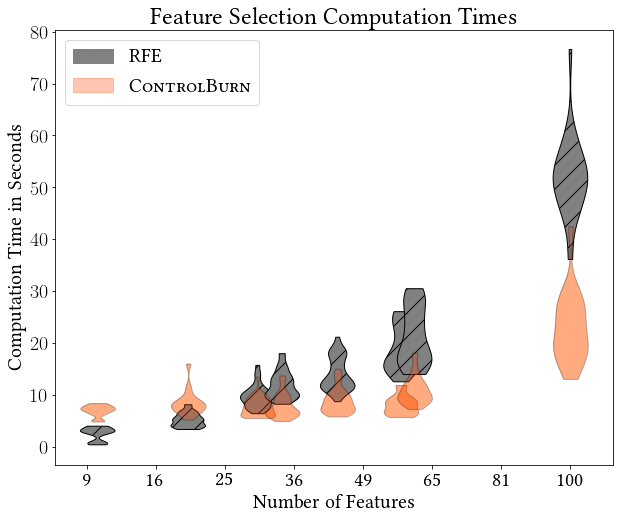

In [67]:
import matplotlib.patches as mpatches
from itertools import repeat
fig = plt.figure(figsize = (10,8))
ax  = fig.add_subplot(111)
plt.violinplot(rfe_to_plot, positions = np.sqrt(results['features'].unique()),showextrema=False)
plt.violinplot(control_burn_to_plot , positions =  np.sqrt(results['features'].unique()),showextrema= False)
plt.ylabel('Computation Time in Seconds')
plt.xlabel('Number of Features')
plt.xticks([3,4,5,6,7,8,9,10],[9,16,25,36,49,65,81,100])
labels = []
def add_label(violin, label,hatch = None):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color,hatch = hatch), label))

positions = np.arange(3,13,3)
p1 = ax.violinplot(rfe_to_plot, positions = np.sqrt(results['features'].unique()),showextrema=False )

for pc in p1['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_hatch('/')
    pc.set_alpha(.99)
    
add_label(p1, "RFE",'/')  
positions = np.arange(1, 10, 2)
p2 = ax.violinplot(control_burn_to_plot , positions =  np.sqrt(results['features'].unique()),showextrema= False)


for pc in p2['bodies']:
    pc.set_facecolor('orangered')
    pc.set_edgecolor('black')

add_label(p2, r'\textsc{ControlBurn}')  


plt.title('Feature Selection Computation Times')
ax.legend(*zip(*labels), loc=2)
plt.savefig('RFEsvg.svg')